In [56]:
# Building a basic selector ML algorithm for picking simulation strategy with inferQ data

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [76]:
PRIMARY_KEY = "RowKey"
qiskit_sim = pd.read_csv("data_clean_sim_auto_worked_qiskit.csv")
inferq_features = pd.read_csv("data_clean_features.csv")
df_dropped = pd.merge(qiskit_sim, inferq_features, on=PRIMARY_KEY, how="inner")

cols = df_dropped.columns.tolist()
# let us remove some columns that we do not need
DROP_COLS = [
    "blob_url",
    "RowKey",
    "PartitionKey",
    "name",
    "serialization_method",
    "qpy_serialization_success",
    "gate_counts",
    "automatic_method"
]

ALL_METHODS = [
    "statevector_saved",
    "statevector",
    "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    "unitary",
    "automatic"
]

DROP_FAILED_SIM = [
    f"{m}_{suffix}"
    for m in ALL_METHODS
    for suffix in (
        "transpiled_size",
        "transpiled_depth",
        "memory_usage",
        "execution_time",
        "gate_counts",
    )
]

FEATURES = [c for c in df_dropped.drop(columns=DROP_COLS).columns.tolist() if c not in DROP_FAILED_SIM]

METHODS = [
    "statevector_saved",
    # "statevector",
    # "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    # "unitary",
    # "automatic"
]

print(FEATURES)
print(len(df_dropped))

['average_clustering_coefficient', 'average_degree', 'average_shortest_path_length', 'central_point_of_dominance', 'circuit_size', 'density_score', 'depth', 'diameter', 'edge_count', 'idling_score', 'locality_ratio', 'max_degree', 'min_cut_upper', 'num_qubits', 'pauli_gate_count', 'radius', 'statevector_saved_entropy', 'statevector_saved_sparsity', 'std_dev_adjacency_matrix', 'two_qubit_gate_count', 'two_qubit_gate_percentage', 'width']
45376


In [77]:
def best_method(row):
    costs = {}
    for m in METHODS:
        t = row.get(f"{m}_execution_time")
        mem = row.get(f"{m}_memory_usage")
        if pd.isna(t) or pd.isna(mem):
            continue
        costs[m] = t
    return min(costs, key=costs.get) if costs else np.nan

df_dropped["best_method"] = df_dropped.apply(best_method, axis=1)
df_clean = df_dropped.dropna(subset=["best_method"])
print(len(df_clean))

45376


# Feature Analysis

In [78]:
# from utils import PlotHistPercentBest

# PlotHistPercentBest(METHODS, FEATURES, df_clean)

In [79]:
# from utils import PlotHeatMapAvg
# PlotHeatMapAvg(METHODS, FEATURES, df_clean)

# Best Method

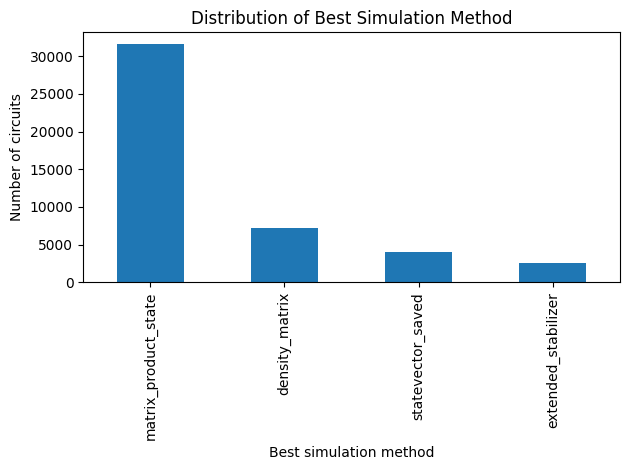

In [80]:
import matplotlib.pyplot as plt

df_clean["best_method"].value_counts().plot(kind="bar")

plt.xlabel("Best simulation method")
plt.ylabel("Number of circuits")
plt.title("Distribution of Best Simulation Method")
plt.tight_layout()
plt.show()


In [81]:
total = len(df_clean)
print(df_clean["best_method"].value_counts())
print(len(df_clean))
print(df_clean["best_method"].value_counts()/total)

best_method
matrix_product_state    31570
density_matrix           7183
statevector_saved        4020
extended_stabilizer      2603
Name: count, dtype: int64
45376
best_method
matrix_product_state    0.695742
density_matrix          0.158300
statevector_saved       0.088593
extended_stabilizer     0.057365
Name: count, dtype: float64


In [82]:
X = df_clean[FEATURES].select_dtypes(include=[np.number])
y = df_clean["best_method"]

# PCA 

# Training Models

In [83]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

TARGET = "best_method"
RANDOM_STATE = 42

X = df_clean[FEATURES]
y = df_clean[TARGET]

y_original = df_clean[TARGET]


X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = train_test_split(
    X, y, y_original,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)
y.value_counts(normalize=True)


best_method
matrix_product_state    0.695742
density_matrix          0.158300
statevector_saved       0.088593
extended_stabilizer     0.057365
Name: proportion, dtype: float64

In [84]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
def PlotConfusionReport(y_test, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        labels=METHODS,
        display_labels=METHODS,
        ax=axes[0],
        xticks_rotation=45,
        normalize=None
    )
    axes[0].set_title("Confusion Matrix (Counts)")
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        labels=METHODS,
        display_labels=METHODS,
        ax=axes[1],
        xticks_rotation=45,
        normalize="true"
    )
    axes[1].set_title("Confusion Matrix (Normalized)")
    plt.tight_layout()
    plt.show()

    # Compute normalized confusion matrix
    cm_norm = confusion_matrix(y_test, y_pred, labels=METHODS, normalize='true')
    
    # Count how many classes have diagonal > 0.7
    correct_diag = np.diag(cm_norm)
    above_70 = np.sum(correct_diag > 0.7)
    
    print(f"Number of classes with >70% correct predictions: {above_70} out of {len(METHODS)}")
    for idx, val in enumerate(correct_diag):
        print(f"{METHODS[idx]}: {val:.2f}")

# Naive Bayes Gaussian

                      precision    recall  f1-score   support

      density_matrix       0.42      0.40      0.41      1437
 extended_stabilizer       0.12      0.87      0.21       521
matrix_product_state       0.94      0.42      0.58      6314
   statevector_saved       0.52      0.72      0.60       804

            accuracy                           0.47      9076
           macro avg       0.50      0.60      0.45      9076
        weighted avg       0.77      0.47      0.53      9076



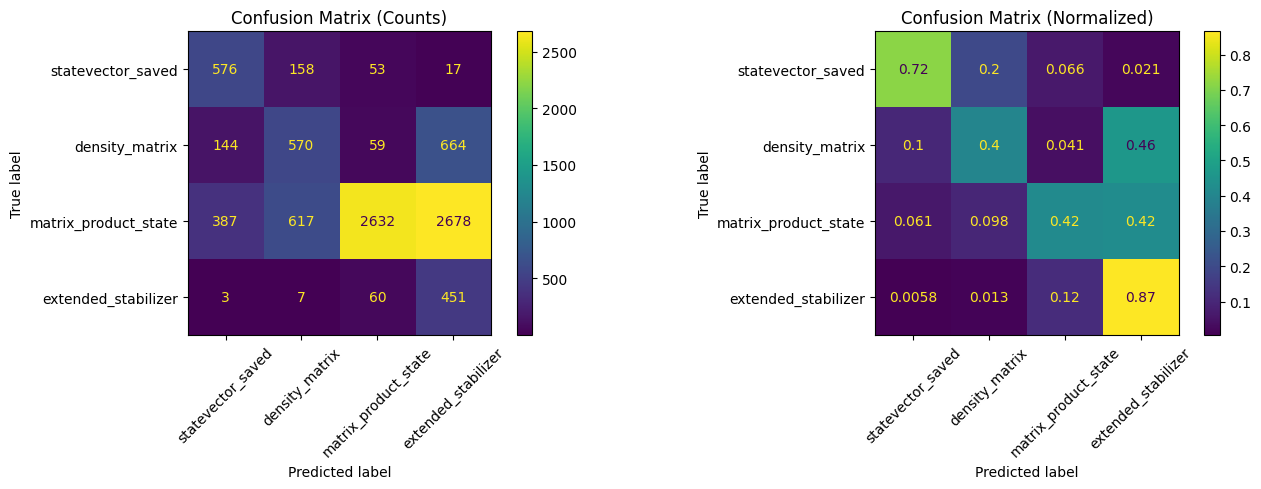

Number of classes with >70% correct predictions: 2 out of 4
statevector_saved: 0.72
density_matrix: 0.40
matrix_product_state: 0.42
extended_stabilizer: 0.87


In [85]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
PlotConfusionReport(y_test, y_pred)


# Logisitic Regression

c:\Users\aadik\InferQ\analysis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                      precision    recall  f1-score   support

      density_matrix       0.50      0.39      0.44      1437
 extended_stabilizer       0.56      0.07      0.13       521
matrix_product_state       0.80      0.90      0.85      6314
   statevector_saved       0.69      0.67      0.68       804

            accuracy                           0.75      9076
           macro avg       0.64      0.51      0.52      9076
        weighted avg       0.73      0.75      0.73      9076



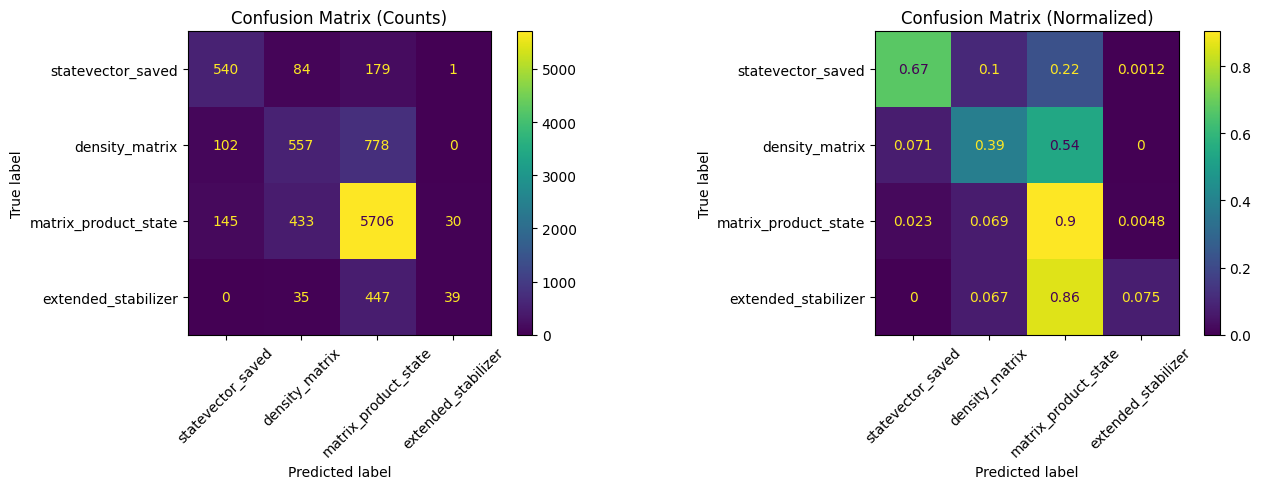

Number of classes with >70% correct predictions: 1 out of 4
statevector_saved: 0.67
density_matrix: 0.39
matrix_product_state: 0.90
extended_stabilizer: 0.07


In [86]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

PlotConfusionReport(y_test, y_pred)
plt.show()


# KNN

                      precision    recall  f1-score   support

      density_matrix       0.49      0.49      0.49      1437
 extended_stabilizer       0.54      0.45      0.49       521
matrix_product_state       0.83      0.85      0.84      6314
   statevector_saved       0.77      0.71      0.74       804

            accuracy                           0.76      9076
           macro avg       0.66      0.63      0.64      9076
        weighted avg       0.75      0.76      0.76      9076



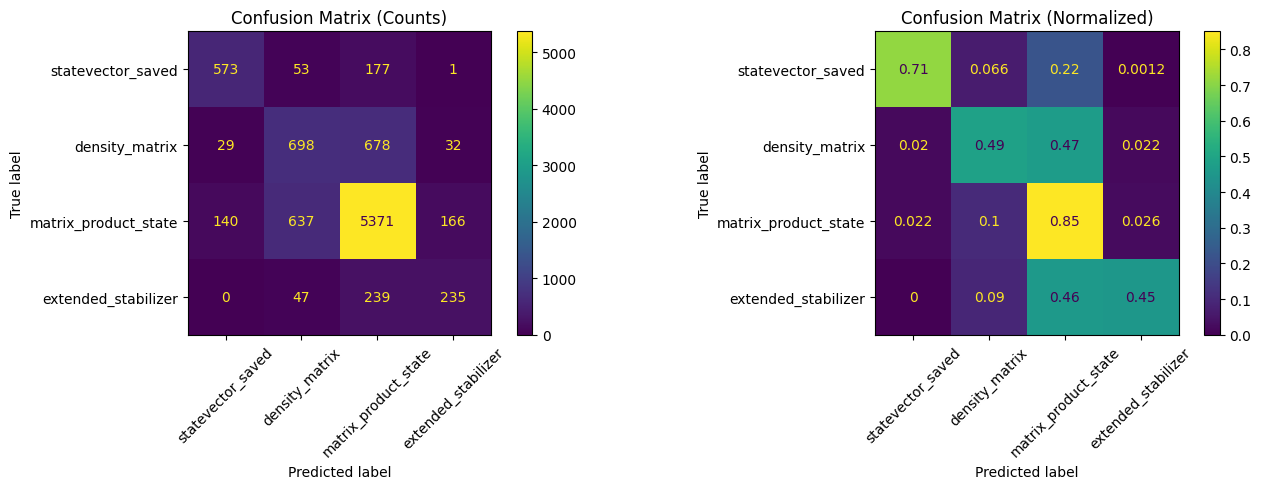

Number of classes with >70% correct predictions: 2 out of 4
statevector_saved: 0.71
density_matrix: 0.49
matrix_product_state: 0.85
extended_stabilizer: 0.45


In [87]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(
    n_neighbors=5
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
PlotConfusionReport(y_test, y_pred)


# Decision Tree

                      precision    recall  f1-score   support

      density_matrix       0.51      0.74      0.61      1437
 extended_stabilizer       0.58      0.43      0.49       521
matrix_product_state       0.88      0.83      0.85      6314
   statevector_saved       0.87      0.75      0.81       804

            accuracy                           0.78      9076
           macro avg       0.71      0.69      0.69      9076
        weighted avg       0.81      0.78      0.79      9076



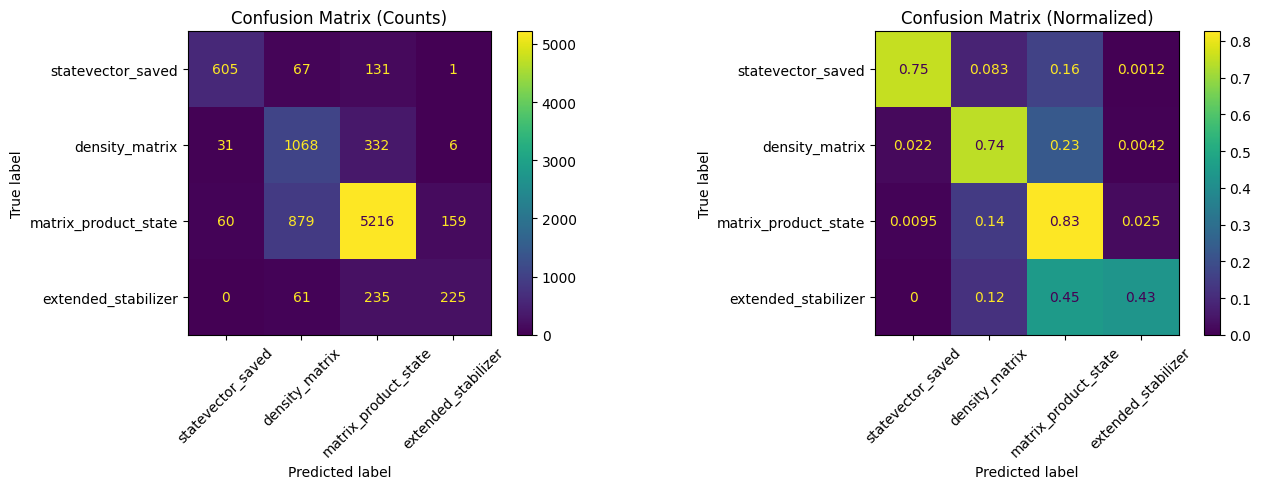

Number of classes with >70% correct predictions: 3 out of 4
statevector_saved: 0.75
density_matrix: 0.74
matrix_product_state: 0.83
extended_stabilizer: 0.43


In [88]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
PlotConfusionReport(y_test, y_pred)
plt.show()


# Random Forest 

                      precision    recall  f1-score   support

   statevector_saved       0.89      0.79      0.84       804
      density_matrix       0.55      0.44      0.48      1437
matrix_product_state       0.83      0.91      0.87      6314
 extended_stabilizer       0.67      0.34      0.45       521

            accuracy                           0.79      9076
           macro avg       0.73      0.62      0.66      9076
        weighted avg       0.78      0.79      0.78      9076



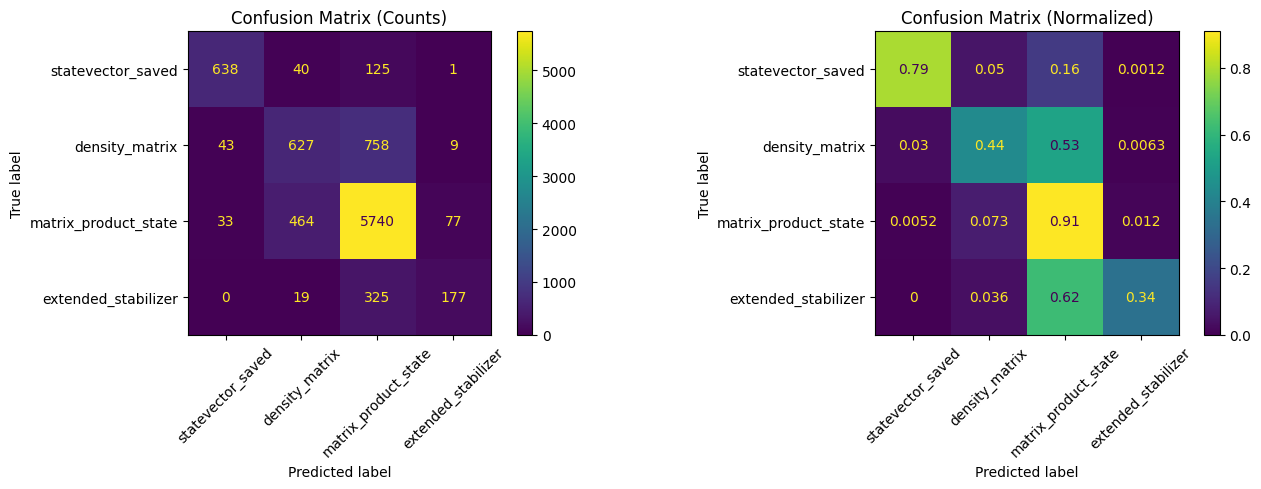

Number of classes with >70% correct predictions: 2 out of 4
statevector_saved: 0.79
density_matrix: 0.44
matrix_product_state: 0.91
extended_stabilizer: 0.34


In [89]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=10,
    n_jobs=-1,
    # class_weight="balanced",
    random_state=RANDOM_STATE
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(
    y_test, y_pred,
    labels=METHODS,
    target_names = METHODS
))

PlotConfusionReport(y_test, y_pred)

# XG Boost

                      precision    recall  f1-score   support

      density_matrix       0.54      0.55      0.54      1437
 extended_stabilizer       0.59      0.49      0.53       521
matrix_product_state       0.86      0.88      0.87      6314
   statevector_saved       0.93      0.89      0.91       804

            accuracy                           0.80      9076
           macro avg       0.73      0.70      0.71      9076
        weighted avg       0.80      0.80      0.80      9076



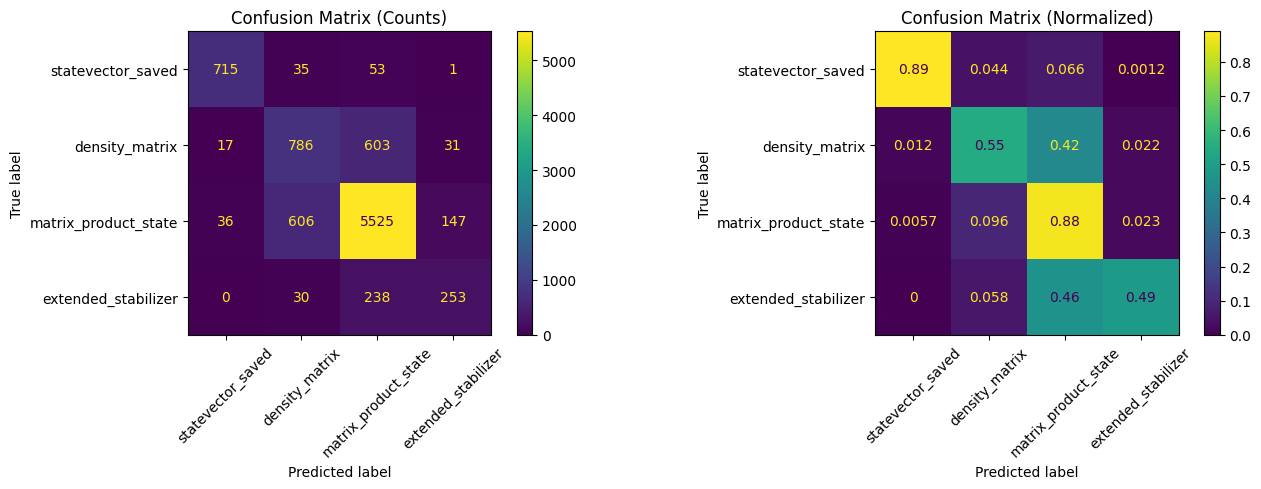

Number of classes with >70% correct predictions: 2 out of 4
statevector_saved: 0.89
density_matrix: 0.55
matrix_product_state: 0.88
extended_stabilizer: 0.49


In [90]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

num_classes = len(le.classes_)

model = XGBClassifier(
    n_estimators=400,
    max_depth=12,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=10,
    objective="multi:softmax",   # softmax since we want class labels
    num_class=num_classes,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    eval_metric="mlogloss"
)

# model = XGBClassifier(
#     n_estimators=200,            # fewer trees → faster, less overfitting
#     max_depth=6,                 # shallower → better generalization
#     learning_rate=0.1,           # slightly higher → faster learning
#     subsample=0.8,               # keep as is
#     colsample_bytree=0.8,        # keep as is
#     min_child_weight=1,          # smaller → allows splits for small classes
#     objective="multi:softmax",
#     num_class=num_classes,
#     n_jobs=-1,
#     random_state=RANDOM_STATE,
#     eval_metric="mlogloss",
#     scale_pos_weight=None         # can handle class imbalance manually if needed
# )

model.fit(X_train, y_train_enc)

y_pred_enc = model.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)

print(classification_report(y_test, y_pred))
PlotConfusionReport(y_test, y_pred)



# SVC 

In [91]:
# print(X_train.isna().sum().sort_values(ascending=False))

                      precision    recall  f1-score   support

      density_matrix       0.49      0.71      0.58      1437
 extended_stabilizer       0.36      0.55      0.43       521
matrix_product_state       0.91      0.76      0.83      6314
   statevector_saved       0.71      0.84      0.76       804

            accuracy                           0.75      9076
           macro avg       0.62      0.71      0.65      9076
        weighted avg       0.80      0.75      0.76      9076



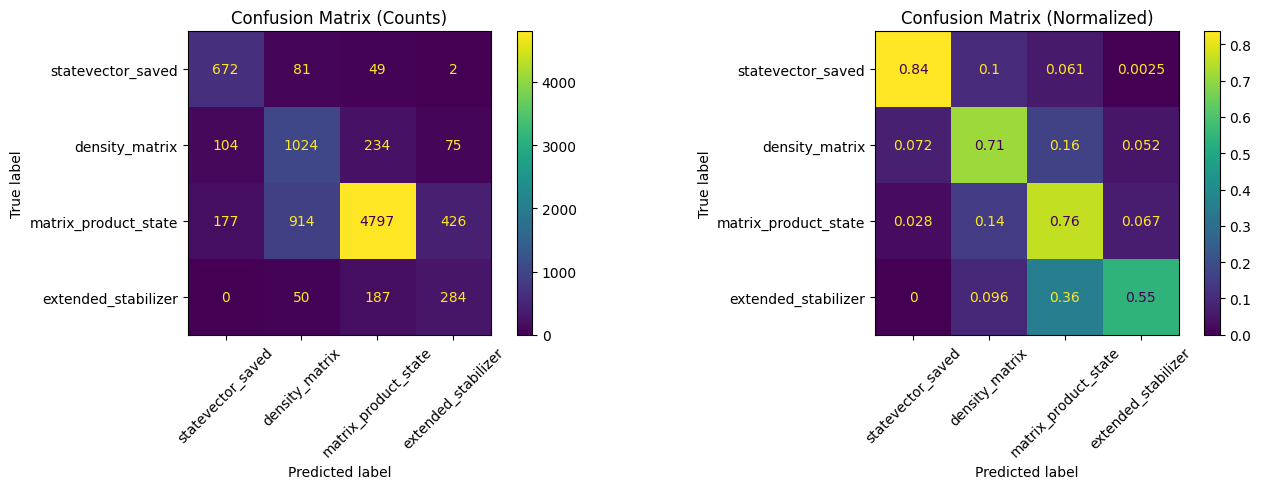

Number of classes with >70% correct predictions: 3 out of 4
statevector_saved: 0.84
density_matrix: 0.71
matrix_product_state: 0.76
extended_stabilizer: 0.55


In [92]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(
        C=10.0,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        max_iter=5000
    ))
])

model.fit(X_train, y_train_enc)

y_pred_enc = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

print(classification_report(
    y_test,
    y_pred,
    labels=le.classes_,
    target_names=le.classes_
))


PlotConfusionReport(y_test, y_pred)


In [93]:
# Now let us compare against the accuracy of automatic
METHODS.append("automatic")

df_auto = df_dropped
print(len(df_auto))

df_auto["best_method"] = df_auto.apply(best_method, axis=1)
df_auto = df_auto.dropna(subset=["best_method"])

total = len(df_auto)

counts = df_auto["best_method"].value_counts()
percentages = counts / total * 100
summary_df = pd.DataFrame({
    "count": counts,
    "percentage": percentages
})
print(summary_df)
METHODS.remove("automatic")

45376
                      count  percentage
best_method                            
automatic             23466   51.714563
matrix_product_state  16080   35.437236
density_matrix         4422    9.745240
extended_stabilizer    1262    2.781206
statevector_saved       146    0.321756
